## Classification models

Now that we have made the segmentation of our customers, we can use this information to create a classification model that will predict the probability of conversion of a customer.

As always, we will start by importing the necessary libraries and loading the data.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import joblib
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)

from sklearn.dummy import DummyClassifier

# linear models
from sklearn.linear_model import LogisticRegression

# tree models
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# svm
from sklearn.svm import SVC

# kNN
from sklearn.neighbors import KNeighborsClassifier

from marketing_case.config import BEST_MODEL_FILE, PROCESSED_DATA_FILE_RFM
from marketing_case.plots import (
    plot_model_performance_metrics,
    plot_coefficients,
    plot_ks_curve,
)
from marketing_case.models import RANDOM_STATE
from marketing_case.models import (
    build_coefficients_dataframe,
    get_mean_and_std_from_grid_search_best_estimator,
    grid_search_cv_classifier,
    train_and_validate_classification_model,
    summarize_model_performance,
)

In [2]:
df = pd.read_parquet(PROCESSED_DATA_FILE_RFM, engine="fastparquet")
df.head()

,Education,Marital_Status,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,...,Complain,Response,MonthsSinceEnrolled,AgeGroup,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,Segment
0,Graduation,Single,58138.0,635,88,546,172,88,88,8,...,0,1,22,46-60,1529,0,0,0,0,Elite
1,Graduation,Single,46344.0,11,1,6,2,1,6,1,...,0,0,3,46-60,21,2,1,0,0,Occasional
2,Graduation,Partner,71613.0,426,49,127,111,21,42,8,...,0,0,10,46-60,734,0,0,0,0,Valuable
3,Graduation,Partner,26646.0,11,4,20,10,3,5,2,...,0,0,4,18-30,48,1,1,0,0,Occasional
4,PhD,Partner,58293.0,173,43,118,46,27,15,5,...,0,0,5,31-45,407,1,1,0,0,Occasional


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Education            2205 non-null   category
 1   Marital_Status       2205 non-null   category
 2   Income               2205 non-null   float64 
 3   MntWines             2205 non-null   int16   
 4   MntFruits            2205 non-null   int16   
 5   MntMeatProducts      2205 non-null   int16   
 6   MntFishProducts      2205 non-null   int16   
 7   MntSweetProducts     2205 non-null   int16   
 8   MntGoldProds         2205 non-null   int16   
 9   NumWebPurchases      2205 non-null   int8    
 10  NumCatalogPurchases  2205 non-null   int8    
 11  NumStorePurchases    2205 non-null   int8    
 12  Complain             2205 non-null   category
 13  Response             2205 non-null   category
 14  MonthsSinceEnrolled  2205 non-null   int8    
 15  AgeGroup             

## Preprocessing setup

Prior to building the model, we need to preprocess the data. We will start by defining the target variable and the features:

In [4]:
X = df.drop(columns=["Response"])
y = df["Response"]

le = LabelEncoder()
y = le.fit_transform(y.values.ravel())

X.shape, y.shape

((2205, 21), (2205,))

In [5]:
le.classes_

array([0, 1])

In [6]:
y[:5]

array([1, 0, 0, 0, 0])

We have seen in the previous notebooks that we have numerical and categorical features. We will need to preprocess them separately. Among the categorical features, we have some that are ordinal and some that are nominal. We will treat them differently, using one-hot encoding for the nominal features and ordinal encoding for the ordinal features.

On the other hand, concerning the numerical features, we have seen that most of them are right-skewed. We will apply a power transformation to these to make them more Gaussian-like. The other numerical features will be transformed using a standard scaler.

In [7]:
columns_one_hot_encoding = [
    "Marital_Status",
    "Complain",
    "HasChildren",
    "HasAcceptedCmp",
    "Segment",
]

columns_ordinal_encoding = [
    "Education",
    "AgeGroup",
    "Children",
    "AcceptedCmpTotal",
]

columns_standard_scaling = [
    "Income",
    "MonthsSinceEnrolled",
]

columns_power_transformer = X.columns[
    X.columns.str.startswith("Mnt") | X.columns.str.startswith("Num")
].tolist()


In [8]:
# check if all columns are accounted for
(
    len(columns_one_hot_encoding)
    + len(columns_ordinal_encoding)
    + len(columns_standard_scaling)
    + len(columns_power_transformer)
) == X.shape[1]

True

Since the exploration of the data has shown that the target column is imbalanced, we will use the stratified split to keep the same distribution of classes in the train and test sets. This will be achieved by using the `StratifiedKFold` class from the `sklearn` library.

The `StratifiedKFold` class will split the data into `n_splits` folds, keeping the same distribution of classes in each fold. This allows us to train the model on different subsets of the data and evaluate its performance on the test set.

In [9]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

The SciKit-Learn library provides a `ColumnTransformer` class that allows us to apply different transformations to different columns of the data. We will use this class to apply the transformations to the data.

We will first test a handful of models to see which one performs best. Then, we will fine-tune the hyperparameters of the best model to improve its performance.

Some models are tree-based models, which do not require scaling of the numerical features. While the other models require scaling. So we are going to define two variables, one for the tree-based models and one for the other models.

In [10]:
preprocessing_tree = ColumnTransformer(
    transformers=[
        (
            "one_hot_encoding",
            OneHotEncoder(drop="if_binary"),
            columns_one_hot_encoding,
        ),
        (
            "ordinal_encoding",
            OrdinalEncoder(),
            columns_ordinal_encoding,
        ),
    ],
    remainder="passthrough",
)

preprocessing_not_tree = ColumnTransformer(
    transformers=[
        (
            "one_hot_encoding",
            OneHotEncoder(drop="if_binary"),
            columns_one_hot_encoding,
        ),
        (
            "ordinal_encoding",
            OrdinalEncoder(),
            columns_ordinal_encoding,
        ),
        (
            "standard_scaling",
            StandardScaler(),
            columns_standard_scaling,
        ),
        (
            "power_transformer",
            PowerTransformer(),
            columns_power_transformer,
        ),
    ]
)

As remembered before, we have an imbalanced target column. Most classification models have a parameter called `class_weight` that allows us to give more importance to the minority class. We will use this parameter, when available, to make the models give more importance to the conversion class.

One of our models, the LGMBClassifier, has a parameter called `scale_pos_weight` that allows us to give more importance to the minority class. We will use this parameter to make the model give more importance to the conversion class. The value of this parameter is calculated as the ratio of the number of samples in the majority class to the number of samples in the minority class:

In [11]:
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]
scale_pos_weight

np.float64(5.621621621621622)

## Evaluating some classification models

Let's define our classifiers. For comparison, a baseline model, `DummyClassifier`, will be defined as well. The baseline model will make predictions based on the stratified strategy, which predicts the most frequent class in the training set:

In [12]:
classifiers = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessing_not_tree,
        "classifier": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": preprocessing_tree,
        "classifier": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": preprocessing_tree,
        "classifier": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=scale_pos_weight,
        ),
    },
    "SVC": {
        "preprocessor": preprocessing_not_tree,
        "classifier": SVC(class_weight="balanced"),
    },
    "KNeighborsClassifier": {
        "preprocessor": preprocessing_not_tree,
        "classifier": KNeighborsClassifier(),
    },
}

Some useful functions were defined to help us evaluate the models and summarize the results:

In [13]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    results = {
        model_name: train_and_validate_classification_model(X, y, kf, **classifier)
        for model_name, classifier in classifiers.items()
    }

df_results = summarize_model_performance(results)

df_results

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.001723,0.010871,0.736961,0.489624,0.134328,0.134328,0.134328,0.476814,0.147433,0.012594
1,DummyClassifier,0.001307,0.009161,0.782313,0.522488,0.172414,0.204082,0.149254,0.447522,0.147401,0.010467
2,DummyClassifier,0.001259,0.007698,0.734694,0.494413,0.145985,0.142857,0.149254,0.496309,0.151019,0.008957
3,DummyClassifier,0.001417,0.008723,0.732426,0.474364,0.106061,0.106061,0.106061,0.484121,0.146544,0.01014
4,DummyClassifier,0.001269,0.00842,0.743764,0.474788,0.096,0.101695,0.090909,0.495273,0.148532,0.009689
5,LogisticRegression,0.061144,0.034418,0.818594,0.801161,0.565217,0.444444,0.776119,0.907754,0.71047,0.095562
6,LogisticRegression,0.078326,0.031567,0.814059,0.792362,0.554348,0.435897,0.761194,0.876487,0.641374,0.109893
7,LogisticRegression,0.076601,0.029237,0.825397,0.848053,0.605128,0.460938,0.880597,0.90077,0.634164,0.105839
8,LogisticRegression,0.078278,0.029201,0.814059,0.815758,0.568421,0.435484,0.818182,0.904303,0.670927,0.107479
9,LogisticRegression,0.078199,0.029878,0.823129,0.827333,0.585106,0.45082,0.833333,0.901596,0.687215,0.108077


As we can see, each model has 5 entries, corresponding to the 5 folds of the cross-validation. We have the following metrics:

- `accuracy`: the proportion of correctly classified samples;
- `balanced_accuracy`: the average of the recall of each class;
- `f1`: the harmonic mean of precision and recall;
- `precision`: the proportion of correctly classified positive samples;
- `recall`: the proportion of positive samples that were correctly classified;
- `roc_auc`: the area under the ROC curve.
- `average_precision`: the area under the precision-recall curve.

We also have some time metrics regarding the training and prediction times, and the total time.

The choice of the best model should consider some factors:

- The metrics: which model has the best performance in the metrics that are most important for the business;
- The time: the model that has the best performance in the metrics and the lowest time should be chosen;
- The interpretability: some models are more interpretable than others. If interpretability is important, the model that is easier to interpret should be chosen.

It happens that the best model in terms of metrics is not always the best model in terms of time or interpretability. So, the choice of the best model should consider all these factors.

Concerning the metrics, some [literature](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432) suggests that the area under the precision-recall curve (AUPRC, represented as `average_precision` on Scikit-Learn) is a better metric for imbalanced datasets than the area under the ROC curve (AUROC, or `roc_auc`). This is because the ROC curve is not sensitive to changes in the false positive rate when the true positive rate is high. The precision-recall curve, on the other hand, is sensitive to changes in the false positive rate when the true positive rate is high.

Since we have 5 folds, we can calculate the mean of the metrics for each model. This will give us a better idea of the performance of each model:

In [14]:
df_results.groupby("model").mean().sort_values(
    "test_average_precision"
)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.001395,0.008974,0.746032,0.491135,0.130958,0.137805,0.125961,0.480008,0.148186,0.010369
DecisionTreeClassifier,0.027016,0.019527,0.824943,0.657491,0.418411,0.419717,0.417549,0.658593,0.274122,0.046543
KNeighborsClassifier,0.037808,0.03015,0.86712,0.62916,0.394672,0.635842,0.288241,0.795753,0.445946,0.067958
LGBMClassifier,0.173,0.028021,0.874376,0.740796,0.569105,0.591591,0.549435,0.891621,0.634743,0.201021
SVC,0.110972,0.060558,0.830385,0.808811,0.580843,0.463849,0.777883,0.893971,0.651779,0.17153
LogisticRegression,0.07451,0.03086,0.819048,0.816933,0.575644,0.445517,0.813885,0.898182,0.66883,0.10537


We can also use boxplots to visualize the distribution of the metrics for each model:

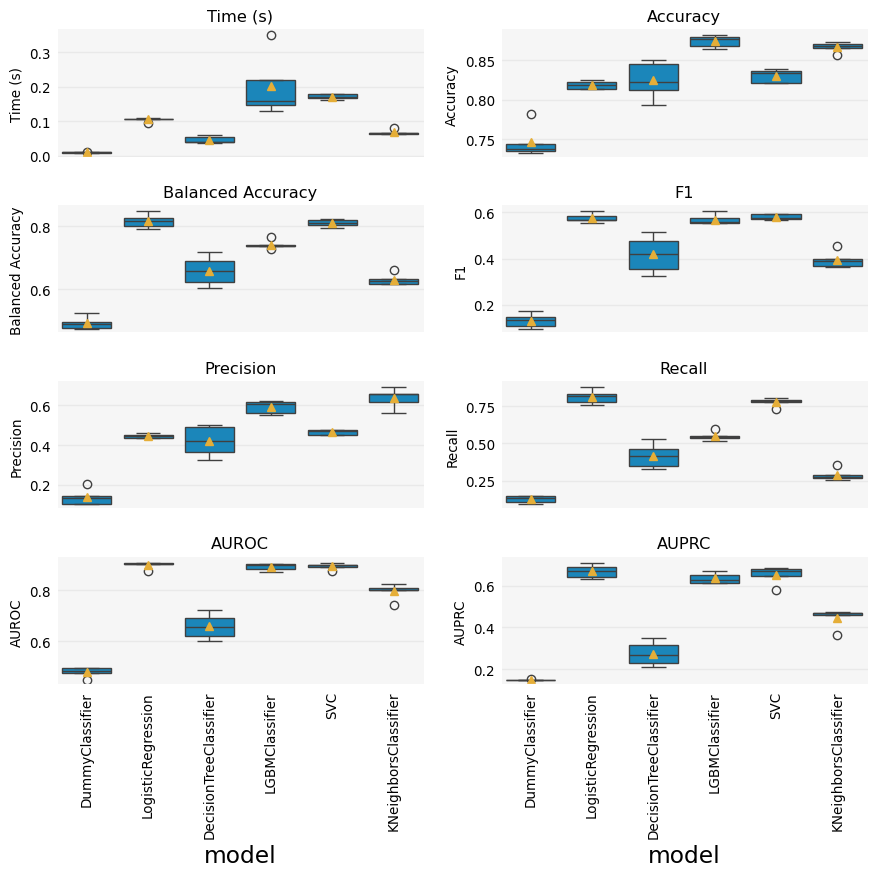

In [15]:
plot_model_performance_metrics(df_results)

We can see that the logistic regression model has the best performance in terms of the chosen metric and is also one of the fastest models. Besides, it is a very interpretable model. So, we will choose the logistic regression model as the best model.

Now that we have chosen the best model, we can fine-tune its hyperparameters to improve its performance.

## Fine-tuning the hyperparameters of the best model

For fine-tuning the hyperparameters, we will use the `GridSearchCV` class from the `sklearn` library. This class allows us to search for the best hyperparameters of a model by testing different combinations of hyperparameters.

In [16]:
param_grid = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2", "elasticnet", None],
    "clf__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
}

In [17]:
clf = LogisticRegression(
    random_state=RANDOM_STATE,
    solver="saga",  # supports all penalties
    max_iter=2500,
    class_weight="balanced",
)

grid_search = grid_search_cv_classifier(
    clf, param_grid, kf, preprocessing_not_tree, refit_metric="average_precision"
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot_encoding',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Marital_Status',
                                                                          'Complain',
                                                                          'HasChildren',
                                                                          'HasAcceptedCmp',
                                                                          'Segment']),
                                                                        ('ordinal_encoding',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'AgeGroup',
                                                                          'Children',
                                                                          'Accept...
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2500,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [18]:
grid_search.fit(X, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot_encoding',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Marital_Status',
                                                                          'Complain',
                                                                          'HasChildren',
                                                                          'HasAcceptedCmp',
                                                                          'Segment']),
                                                                        ('ordinal_encoding',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'AgeGroup',
                                                                          'Children',
                                                                          'Accept...
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2500,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [19]:
grid_search.best_params_

{'clf__C': 1, 'clf__l1_ratio': 0.1, 'clf__penalty': 'elasticnet'}

In [20]:
grid_search.best_score_

np.float64(0.6690593128510551)

It is not a great increase in metrics performance, but it is an improvement. We can see that the fine-tuned model has an elastic net regularization with a L1 ratio of 0.1 and a C value of 1. This means that the model is using a combination of L1 and L2 regularization, while the vanilla model (LogisticRegression with default parameters) uses only L2 regularization.

It is a good practice to check the other metrics to see if the fine-tuned model is not sacrificing performance in other metrics to improve the chosen metric:

In [21]:
get_mean_and_std_from_grid_search_best_estimator(grid_search)

,score,std
accuracy,0.819048,0.004625
balanced_accuracy,0.816933,0.019649
f1,0.575644,0.017738
precision,0.445517,0.009594
recall,0.813885,0.042544
roc_auc,0.898117,0.011115
average_precision,0.669059,0.028576


We see that our model highly favors recall in detriment of precision. This is because the model is giving more importance to the conversion class, which is the minority class. It seems fine, as we are more interested in capturing the conversion cases.

## Interpreting the model

The coefficients of the logistic regression model can give us some insights into the importance of each feature in predicting the probability of conversion. We can plot the coefficients to see which features have the most impact on the probability of conversion:

In [22]:
coefs = build_coefficients_dataframe(
    grid_search.best_estimator_["clf"].coef_[0],
    grid_search.best_estimator_["preprocessor"].get_feature_names_out(),
)

coefs

,coefficient
one_hot_encoding__Segment_Dormant,-2.782483
power_transformer__MntWines,-1.227801
one_hot_encoding__Segment_Occasional,-1.151704
power_transformer__NumStorePurchases,-1.125617
power_transformer__MntRegularProds,-0.805855
one_hot_encoding__HasChildren_1,-0.690007
one_hot_encoding__Complain_1,-0.547585
power_transformer__MntFishProducts,-0.434350
ordinal_encoding__AgeGroup,-0.043103
power_transformer__MntFruits,-0.025627


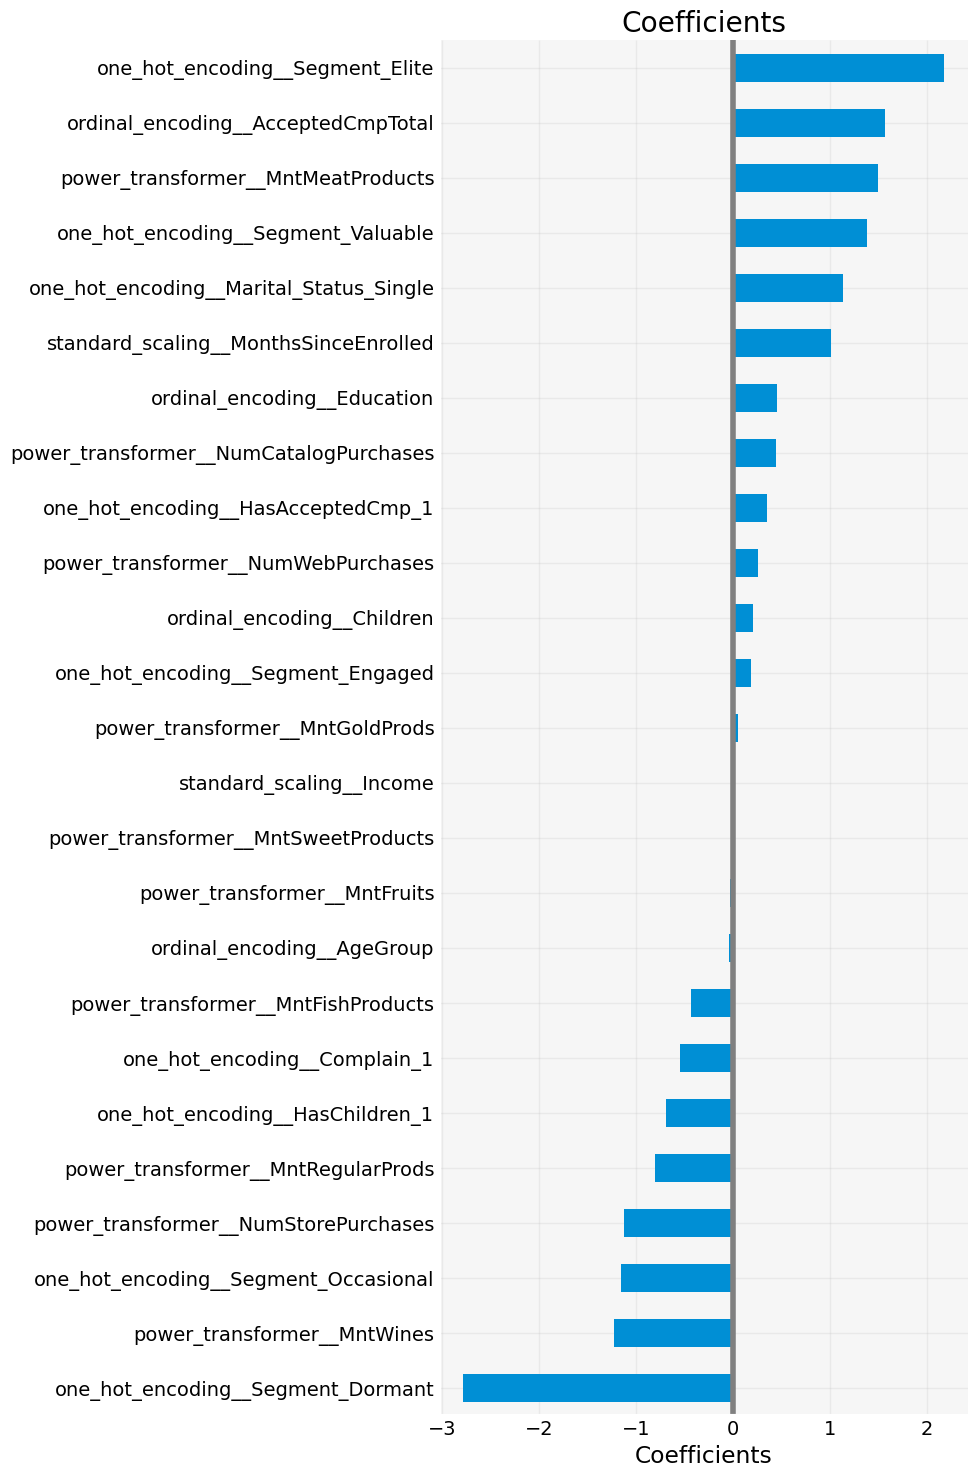

In [23]:
plot_coefficients(coefs)

The coefficients are the weights that the model assigns to each feature. The higher the absolute value of the coefficient, the more important the feature is in predicting the probability of conversion. The sign of the coefficient indicates the direction of the relationship between the feature and the target variable. A positive coefficient means that the feature has a positive impact on the probability of conversion, while a negative coefficient means that the feature has a negative impact on the probability of conversion.


So, we clearly see that:

- `Elite` segment has the highest positive impact on the probability of conversion;
- The more accepted offers a customer has, the higher the probability of conversion;
- Customers which expend more on meat products have a higher probability of conversion;
- `Dormant` segment has the highest negative impact on the probability of conversion;
- Customers which expend more on wine products have a lower probability of conversion.

Features with zero or near-zero coefficients have little or no impact on the probability of conversion. We are using a regularized logistic regression model, which means that the model is penalized for having too many features. This is why some features have zero or near-zero coefficients. The model is trying to reduce the number of features to make the model simpler and more interpretable. Then, we can see that the following features have little or no impact on the probability of conversion:

- gold products;
- income;
- sweet and fruit products;
- age group;

Again, this does not mean that these features are not important. It means that the model is trying to reduce the number of features to make the model simpler and more interpretable. The remaining features are the most important features in predicting the probability of conversion. And it makes sense, as we have seen in the exploratory data analysis and the segmentation of customers, that the age group, for example, is not really related to the response variable. At least not as much as the other features. The previous segmentation of customers has aggregated some pieces of information into the segments so that the model can use the segments instead of the individual features.

All of these results are aligned with the insights we have gained from the exploratory data analysis and the segmentation of customers. But now we have a model that can predict the probability of conversion of a customer based on these features, we can quantify the impact of each feature on the probability of conversion.


Mathematically, the coefficients represent the change in the log-odds of the target variable for a one-unit change in the feature. In other words, the coefficients represent the impact of the feature on the probability of conversion.

Odds are the ratio of the probability of an event happening to the probability of the event not happening. The log-odds are the natural logarithm of the odds. The logistic regression model uses the log-odds to make predictions.

$$
\text{odds} = \frac{P(y=1)}{1 - P(y=1)} = \frac{P(y=1)}{P(y=0)}
$$

$$
\text{log-odds} = w_0 + w_1 X_1 + w_2 X_2 + \ldots + w_n X_n
$$

Where $w_0$ is the intercept term, $w_1, w_2, \ldots, w_n$ are the coefficients, and $X_1, X_2, \ldots, X_n$ are the features.

For a numerical feature, the coefficient represents the change in the log-odds of the target variable for a one-unit change in the feature. For example, if the coefficient of a numerical feature is 0.5, it means that a one-unit increase in the feature is associated with a 0.5 increase in the log-odds of the target variable.

While for a categorical feature, the coefficient represents the change in the log-odds of the target variable for a one-unit change from the reference category to the category represented by the feature. Considering a binary feature, if the coefficient is 0.5, it means that the category represented by the feature is associated with a 0.5 increase in the log-odds of the target variable compared to the reference category. For a multi-class feature, the interpretation is similar.


Interpreting directly the coefficients of the logistic regression model can be difficult, especially when the features are not scaled, since log-odds is a not intuitive measure. To make the interpretation easier, we can transform the coefficients into odds ratios. 

$$
\text{odds ratio} = e^{w}
$$

Where $w$ is the coefficient of the feature.

The odds ratio is a more intuitive measure than the log-odds, as it represents the change in the odds of the target variable for a one-unit change in the feature. An odds ratio greater than 1 means that the feature has a positive impact on the probability of conversion, while an odds ratio less than 1 means that the feature has a negative impact on the probability of conversion.

Let's consider a numerical feature with a coefficient of 0.5. The odds ratio of this feature is $e^{0.5} \approx 1.65$. This means that a one-unit increase in the feature is associated with a 1.65 increase in the odds of the target variable. Or, in percentage terms, a 65% increase in the odds of the target variable.

Meanwhile, let's consider a binary feature with a coefficient of 0.5. The odds ratio of this feature is $e^{0.5} \approx 1.65$. This means that the category represented by the feature is associated with a 1.65 increase in the odds of the target variable compared to the reference category. For a multi-class feature, the interpretation is similar, but the odds ratio is calculated for each category compared to the reference category.

In [24]:
coefs_odds = coefs.copy()
coefs_odds["odds_ratio"] = np.exp(coefs_odds["coefficient"])
coefs_odds = coefs_odds.drop(columns="coefficient")

coefs_odds

,odds_ratio
one_hot_encoding__Segment_Dormant,0.061885
power_transformer__MntWines,0.292936
one_hot_encoding__Segment_Occasional,0.316098
power_transformer__NumStorePurchases,0.324452
power_transformer__MntRegularProds,0.446706
one_hot_encoding__HasChildren_1,0.501573
one_hot_encoding__Complain_1,0.578345
power_transformer__MntFishProducts,0.647686
ordinal_encoding__AgeGroup,0.957812
power_transformer__MntFruits,0.974699


Using `MntMeatProducts` as an example for a numerical feature, we see that the odds ratio is ~4.47. This means that a one-unit increase in the `MntMeatProducts` feature is associated with a 4.47 increase in the odds of the target variable. Or, in percentage terms, a 347% increase in the odds of the target variable.

For `HasAcceptedCmp_1`, a binary feature, we have to consider that we have set the OneHotEncoder to drop the first category when dealing with binary features. So, the reference category is the category that was dropped. In this case, the reference category is `0`, that is why there is not `HasAcceptedCmp_0` in the coefficients list. The odds ratio is ~1.42. This means that the category represented by the `HasAcceptedCmp_1` feature is associated with a 1.42 increase in the odds of the target variable compared to the reference category. So, you have 1.42 times more chance of converting if you have converted at least one previous campaign.

Finally, considering now a multi-class feature, `Segment`. We have set the OneHotEncoder to drop the first category only for binary features. Since `Segment` has 5 categories, we have 5 coefficients. It is easier to interpret the odds ratio of a multi-class feature by comparing the odds ratio of each category to a reference category. This can be done dividing the odds ratio of each category by the odds ratio of the reference category. Let's consider the Dormant category as the reference category. The odds ratio of the Dormant category is 1. 

$$
\text{Relative Odds Ratio} = \frac{\text{Odds Ratio of Segment}}{\text{Odds Ratio of Lowest Segment (Dormant)}}
$$

Applying this to your data:

| Segment  | Absolute Odds Ratio | Adjusted (Relative to Dormant) |
|----------|---------------------|--------------------------------|
| **Dormant** | 0.0619  | **1.00 (Baseline)** |
| **Occasional** | 0.3161  | $ \frac{0.3161}{0.0619} = 5.11 $ |
| **Engaged** | 1.2011  | $ \frac{1.2011}{0.0619} = 19.40 $ |
| **Valuable** | 3.9805  | $ \frac{3.9805}{0.0619} = 64.28 $ |
| **Elite** | 8.8405  | $ \frac{8.8405}{0.0619} = 142.76 $ |

- **Occasional customers** are **5.1 times** more likely to convert compared to Dormant customers.
- **Engaged customers** are **19.4 times** more likely than Dormant customers.
- **Valuable customers** are **64.3 times** more likely than Dormant customers.
- **Elite customers** are **142.8 times** more likely than Dormant customers.

These are important insights that can help the marketing team to focus on the most valuable customers and improve the conversion rate. The figures are quite impressive, showing that the segmentation of customers is a powerful tool to predict the probability of conversion.

Plottiing the odds ratio can help us to visualize the impact of each feature on the probability of conversion:

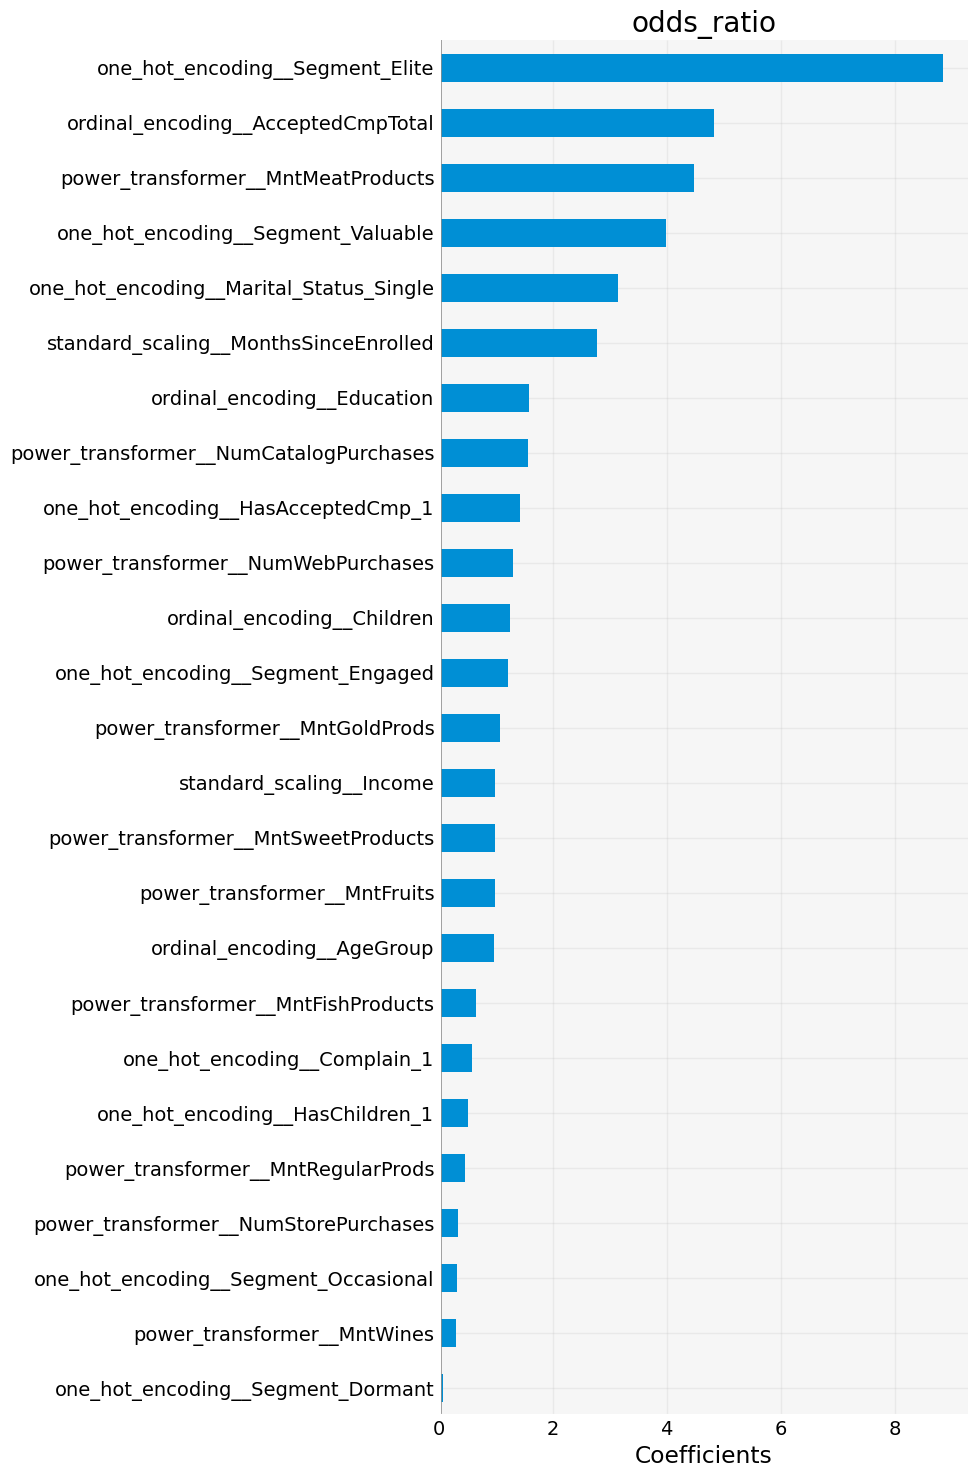

In [25]:
plot_coefficients(coefs_odds, "odds_ratio")

The model can be exported to be used in a production environment or in future analysis, like the one we are going to do in the next notebook:

In [26]:
joblib.dump(grid_search.best_estimator_, BEST_MODEL_FILE)

['/home/chicolucio/Dropbox/technology/python/projects/ml/marketing_case/models/best_model.joblib']

## Visualizing the model performance

We have seen before the metrics for our fine-tuned model. However, an image is worth a thousand words. Let's plot the ROC curve, the precision-recall curve and confusion matrices to visualize the performance of our model. One should have in mind, though, that these visualizations are not ideal to measure generalization performance. They are more useful to summarize the results and to communicate the performance of the model to (technical) stakeholders.

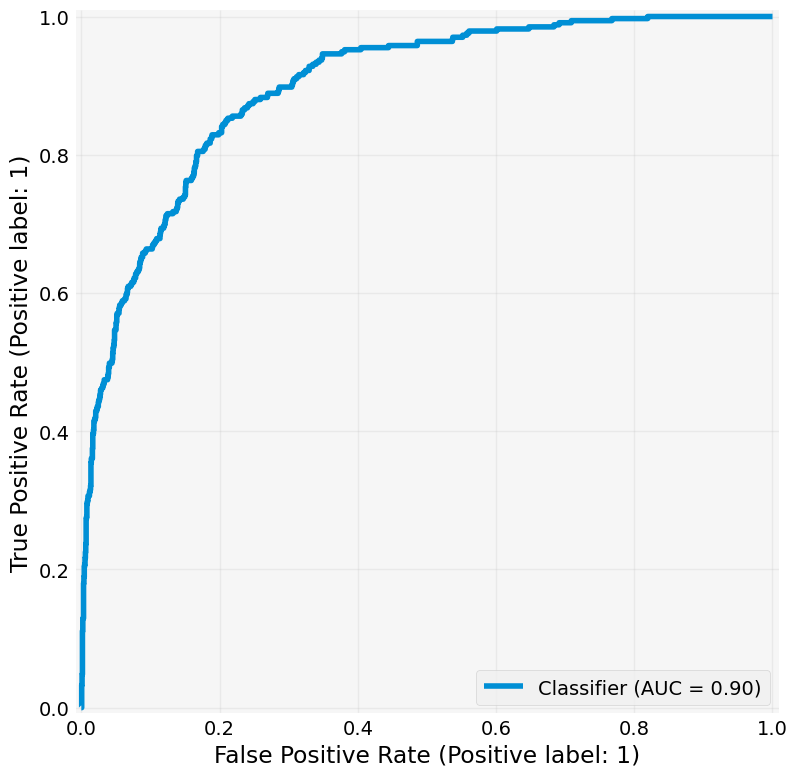

In [27]:
y_pred = cross_val_predict(
    grid_search.best_estimator_, X, y, cv=kf, n_jobs=-1, method="decision_function"
)

roc = RocCurveDisplay.from_predictions(y, y_pred)

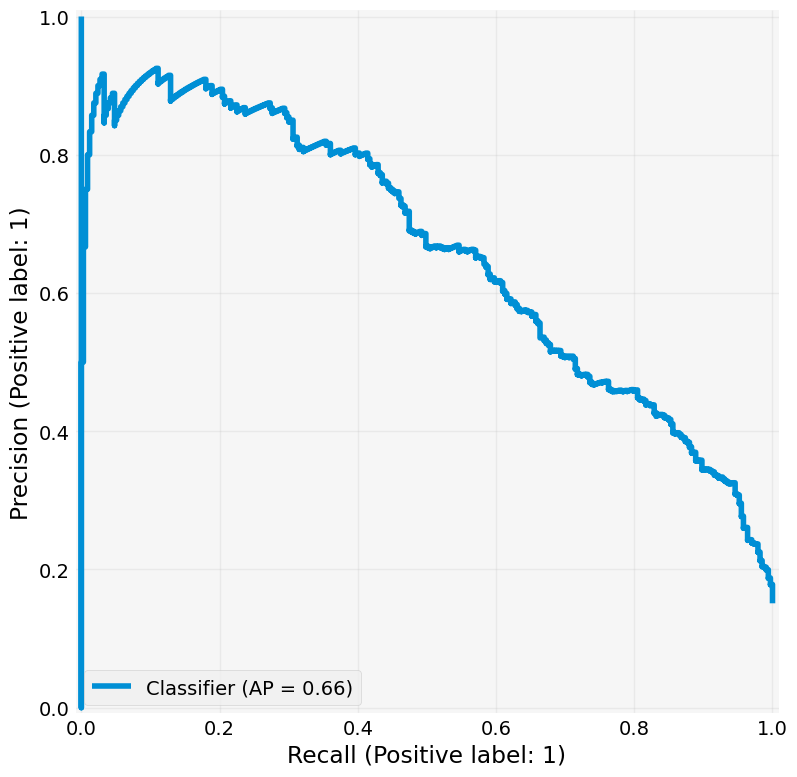

In [28]:
prc = PrecisionRecallDisplay.from_predictions(y, y_pred)

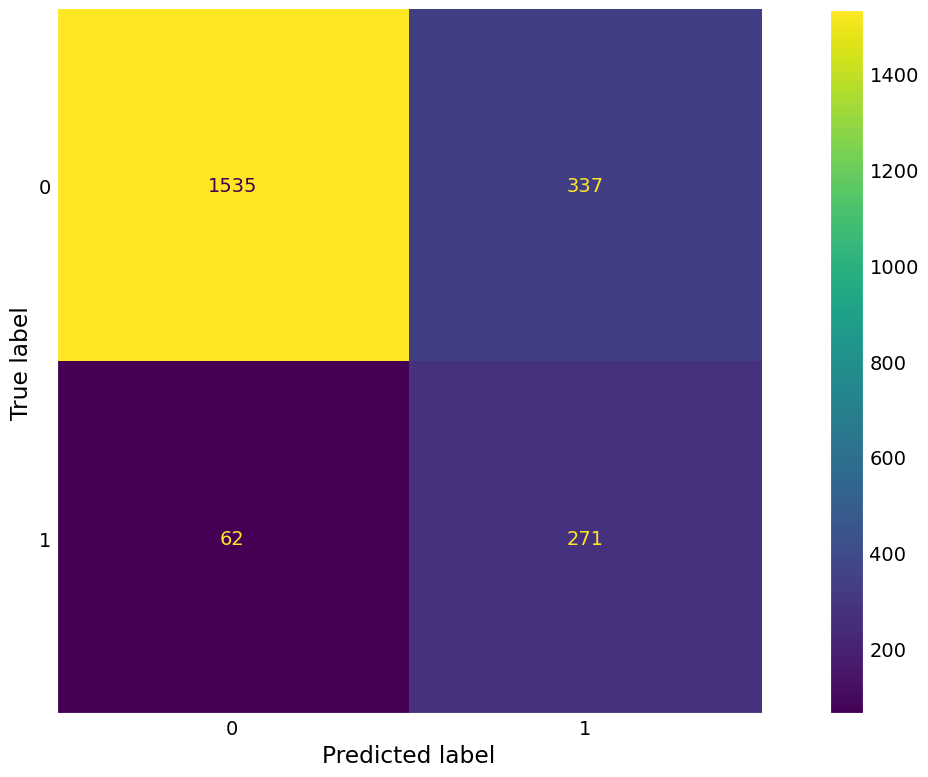

In [29]:
y_pred = cross_val_predict(
    grid_search.best_estimator_, X, y, cv=kf, n_jobs=-1, method="predict"
)

ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.grid(False)
plt.show()

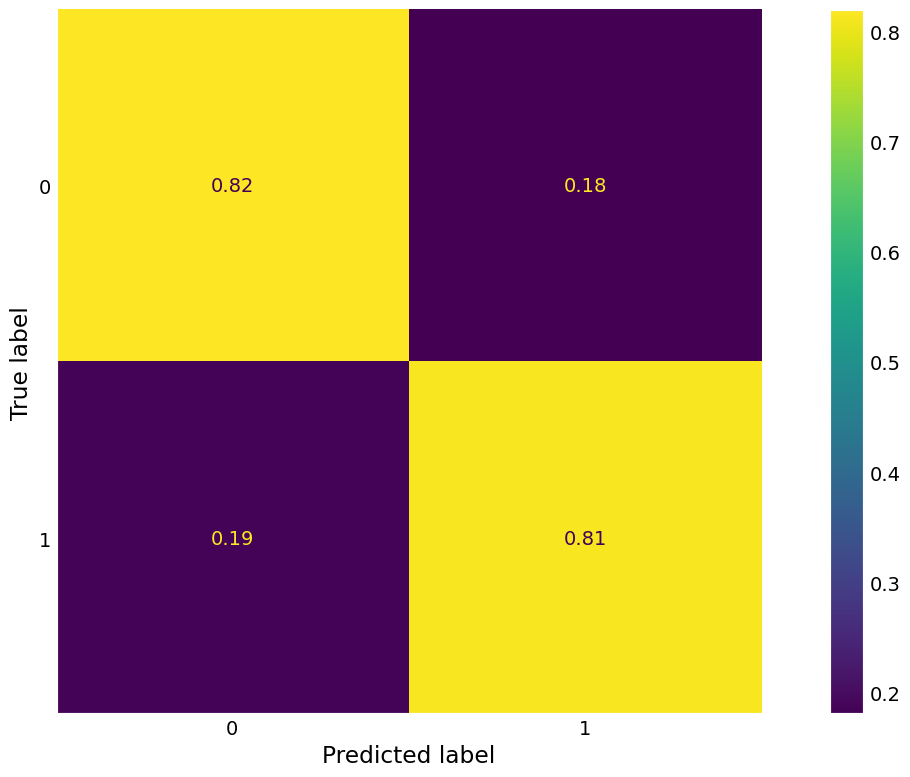

In [30]:
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize="true")
plt.grid(False)
plt.show()

Another plot that could be interesting, although not so common, is the Kolmogorov-Smirnov plot.

The Kolmogorov-Smirnov (KS) plot is a way to check how well a binary classification model separates two groups: positives (class = 1) and negatives (class = 0). It helps us understand if the model is making clear distinctions between the two classes based on the probabilities it assigns.

The KS plot is based on something called the Cumulative Distribution Function (CDF), which is just a way of showing how the probabilities are distributed in each class. Imagine listing all predicted probabilities for a class in order from smallest to largest. The CDF tells us, for each probability value, how many cases fall at or below that value.

Consider plot below: 

- The blue line represents the positive class (y=1). It shows how many actual positive cases have a predicted probability less than or equal to a given value.
- The red line represents the negative class (y=0). It shows how many actual negative cases have a predicted probability less than or equal to that value.
- The KS statistic is the biggest vertical gap between the two lines. This gap tells us how well the model is distinguishing between positives and negatives.

The KS statistic is a number between 0 and 1 that indicates how well the model separates the two classes:
- A high KS value (closer to 1) means the model is doing a good job distinguishing between positives and negatives.
- A low KS value (close to 0) means the model struggles to tell the two classes apart.

If the KS value is greater than 0.4, it usually means the model is making strong distinctions between the two classes.

This plot is a great way to visually confirm how well a model is performing beyond standard metrics like accuracy and AUC-ROC.

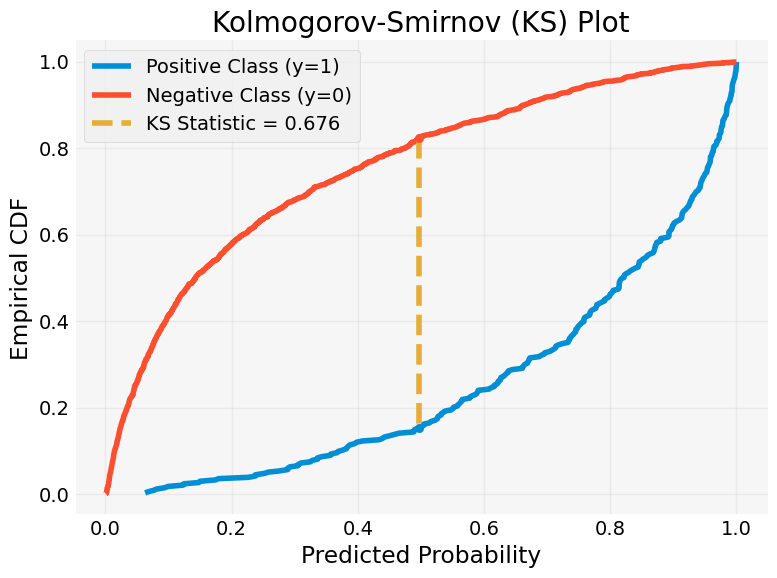

In [31]:
# get probabilities for the best model
y_pred_proba = grid_search.best_estimator_.predict_proba(X)[:, 1]

plot_ks_curve(y, y_pred_proba)